<a href="https://colab.research.google.com/github/adieulev/Certificate-DS-2021/blob/main/Labs/Lab2021_RF_withQ_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#-Random-forests-&amp;-Neural-networks..." data-toc-modified-id="-Random-forests-&amp;-Neural-networks...-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="darkorange"> Random forests &amp; Neural networks...</font></a></span></li></ul></li><li><span><a href="#1.---Random-forests-" data-toc-modified-id="1.---Random-forests--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. <font color="darkred">  Random forests </font></a></span><ul class="toc-item"><li><span><a href="#--Random-forests-for-time-series-prediction---simulated-data-" data-toc-modified-id="--Random-forests-for-time-series-prediction---simulated-data--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><font color="darkred">  Random forests for time series prediction - simulated data </font></a></span></li><li><span><a href="#-For-a-few-cells,-you-have-to-complete-a-few-lines-of-code.-The-solution-is-always-given-in-the-cell-just-below." data-toc-modified-id="-For-a-few-cells,-you-have-to-complete-a-few-lines-of-code.-The-solution-is-always-given-in-the-cell-just-below.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><font color="darkorange"> For a few cells, you have to complete a few lines of code. The solution is always given in the cell just below.</font></a></span></li><li><span><a href="#A-first-Tree-regressor" data-toc-modified-id="A-first-Tree-regressor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>A first Tree regressor</a></span></li><li><span><a href="#Regression-Forest" data-toc-modified-id="Regression-Forest-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Regression Forest</a></span></li></ul></li><li><span><a href="#-Random-forests-for-time-series-prediction---Inflation-prediction-" data-toc-modified-id="-Random-forests-for-time-series-prediction---Inflation-prediction--2"><span class="toc-item-num">2&nbsp;&nbsp;</span><font color="darkred"> Random forests for time series prediction - Inflation prediction </font></a></span></li></ul></div>

<a href="https://colab.research.google.com/github/adieulev/Certificate-DS-2021/blob/main/Lab2021_RF_withQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=darkcyan>  Machine Learning in Python </font>

### <font color=darkorange> Random forests & Neural networks...</font>

## 1. <font color=darkred>  Random forests </font>

### <font color=darkred>  Random forests for time series prediction - simulated data </font>

Consider a Markov chain, given by $X_0 = x_0$ for $x_0\in \mathbb{R}^d$ and, for $k\geqslant 0$,
$$
X_{k+1} = \rho X_k + \sigma_X\varepsilon_k\,\,\, [2\pi]\,
$$ 
where $(\epsilon_k)_{k\geqslant 0}$ are i.i.d. standard Gaussian vectors in $\mathbb{R}^d$ $\sim {\sf N}(0,{\bf I}_d)$.

The observation model is
$$ 
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$
where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$ and
$$
f:\begin{cases}
\mathbb{R}^d\to\mathbb{R}\\
{\bf x} \mapsto \sum_{i=1}^{d}\cos(x_i)
\end{cases}\,.
$$
The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

Start with a few imports, in particular the function ``RandomForestRegressor`` of sklearn that enables to apply the random forest algorithm in python.

In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'Random-Forests',
    'session_owner': 'Aymeric',
    'sender_name': input("Your name:"),
}
send('started',1)

Your name:a


<Response [200]>

<font color=blue> The following cell allows me to track your progress and see some of your results. You can use your first name or a  pseudonym if you prefer! <br>
When you see a "send" function, just ignore it !
</font>

### <font color=darkorange> For a few cells, you have to complete a few lines of code. The solution is always given in the cell just below.</font> 

In the following cell, we define a function that takes as input the size $d$ of the vector $x_0$, the size $n$ of the dataset, the noise levels $\sigma_X$ of the autoregressive model and $\sigma_Y$ of the observed values and the parameter $\rho$ in the autoregressive model.

The function outputs data following the model described above.

In [3]:
# function to sample a dataset 
def sample_data_ar(rho,sigmax,sigmay,n,d):
    X       = np.zeros(shape=(n,d))
    Y       = np.zeros(n)
    epsilon = np.random.normal(loc=0,scale=1,size = X.shape)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = (np.sum(np.cos(X[0,:])) + sigmax*eta[0])
    for k in range(1,n):
        X[k,:] = (rho*X[k-1,:] + sigmax*epsilon[k,:])%(2*np.pi)
        Y[k]   = np.sum(np.cos(X[k,:])) + sigmay*eta[k]
    return X, Y

In [43]:
# set parameters
n = 4000
d = 2

rho    = 0.9

sigmax = 0.1 
sigmay = 0.3

Matrices X and Y containing data simulated according to the observation model described above may now be computed.

In this simulated toy model, the values of the hidden Markov chain $X_k$ are available in the matrix $X$. 
In practice, only the vector $Y$ is observed (the values of $X_k$ must be estimated sequentially).

<strong><font color=darkorange> Q1</font></strong>: Generate the data X,Y using the ```sample_data_ar``` function

In [44]:
# sample data  
X,Y = sample_data_ar(rho, sigmax,sigmay, n, d)

<strong><font color=darkorange> Solution 1</font></strong>

In [45]:
# sample data  
X, Y = sample_data_ar(rho,sigmax,sigmay,n,d)

To evaluate different algorithms, the dataset is decomposed into training and test data.
In this type of time series analysis, the training data are the first values of $Y_k$ and the test are the last one. This corresponds to situations where one wants to predict future values of $Y$ given historical data.
This is somehow different form the i.i.d. case where taining and test data are chosen randomly using the function ``sklearn.model_selection.train_test_split``

In [46]:
# split variables and observations, using 90% of the data set to estimate f 
import pandas as pd
if d==4:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2', 'X3', 'X4'])
if d==2:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2'])
df['Y'] = Y

nb_data_train = int(0.95*n)
nb_diff       = n-nb_data_train
df.head()
X_train = df.iloc[0:nb_data_train,:-1] 
X_test  = df.iloc[-nb_diff:,0:-1]
X_train.head()
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1]

We can visualize the data in the following graph, with the colors corresponding to the value of Y.

<strong><font color=darkorange> Q2</font></strong>: Generate a scatter plot of the first two coordinates of X,  using the value of Y to fix the colors.

In [47]:
#Complete here

#Keep
send(plt, 2)

! Warning, your figure is blank !
Make sure the send function is in the same cell as the plot, or send the matplotlib figure itself.


<Response [200]>

<Figure size 432x288 with 0 Axes>

<strong><font color=darkorange> Solution 2</font></strong>

<Response [200]>

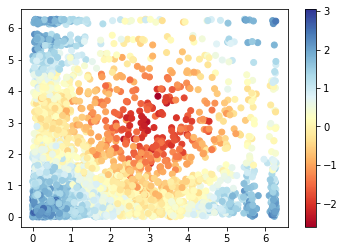

In [48]:
plt.scatter(X[:,0],X[:,1], c=Y, cmap=plt.cm.RdYlBu)
plt.colorbar()
send(plt, 3)

<strong><font color=darkorange> Q3</font></strong>: change the parameters rho to 0.1 et re-run the cells, to see the impact on the distribution of X.

### A first Tree regressor

At first, we can perform regression using a Regression Tree:

<strong><font color=darkorange> Q4</font></strong>: In the following cell, we focus on the two most important steps with sklearn:
- defining the model. Chose the depth of the tree to be 2 (you can also try different values) 
- fitting the model
Complete the two lines needed to do so

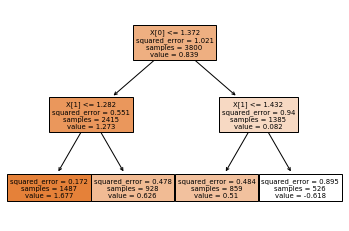

'syntehtic_data_dec_tree.pdf'

In [49]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split

clf = DecisionTreeRegressor(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

plot_tree(clf, filled=True)
send(plt, 4)
plt.show()

    
import graphviz 
dot_data = export_graphviz(clf, filled=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("syntehtic_data_dec_tree") 

<strong><font color=darkorange> Solution 4</font></strong>

In [50]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split

clf = DecisionTreeRegressor(max_depth=3, random_state=0)
clf.fit(X_train.values, Y_train.values)

#plot_tree(clf, filled=True)
# send(plt, 5)
# plt.show()


# import graphviz 
# dot_data = export_graphviz(clf, filled=True, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("syntehtic_data_dec_tree") 

DecisionTreeRegressor(max_depth=3, random_state=0)

We can visualize the frontiers on the first 2 dimensions using the ```contourf``` function

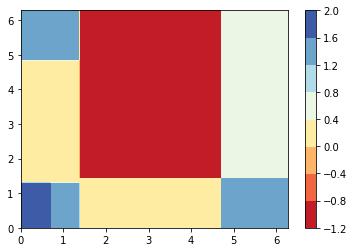

In [51]:
if d==2:
    plot_step = 0.02
    x_min, x_max = 0, 2*np.pi
    y_min, y_max = 0, 2*np.pi
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    plt.show()

<strong><font color=darkorange> Q5</font></strong>:
- Is this tree coherent with your intuition looking at the scatter plot?
- Do you think the classification accuracy is good enough (are there enough details?)
- Modify the following cell to have deeper trees (depths =5, 10 for ex). What do you observe?

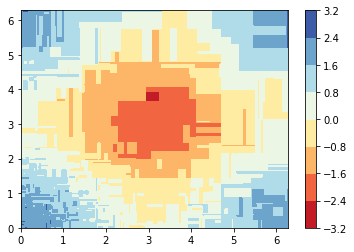

In [52]:
if d==2:
    clf = DecisionTreeRegressor(max_depth=14, random_state=0)
    clf.fit(X_train.values, Y_train.values)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    send(plt,6)
    plt.show()

<strong><font color=darkorange> Sol 5</font></strong>:
- The tree is coherent but not good enough
- We have a much better regression function for a higher depth

Yet, it seems we  overfit (the plot is less regular than we think it should be: the learned model adapts "too much" to the training data). We can check the cross validation error depending on the depth of the tree.

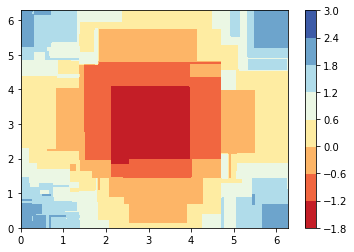

In [55]:
if d==2:
    clf = DecisionTreeRegressor(max_depth=8, random_state=0)
    clf.fit(X_train.values, Y_train.values)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    plt.show()

In [54]:

from sklearn.model_selection import cross_val_score

for depth in range(1,15):
    clf = DecisionTreeRegressor(max_depth=depth, random_state=0)
    cvs = cross_val_score(clf, X_train.values, Y_train.values, cv=10)
    cvsm = cvs.mean()
    print('depth', depth, 'score', cvsm )

depth 1 score 0.3059732077354048
depth 2 score 0.5798514521408162
depth 3 score 0.7397198103247626
depth 4 score 0.8207684060499227
depth 5 score 0.8553084624998055
depth 6 score 0.875657408869172
depth 7 score 0.8845319514551624
depth 8 score 0.8825718728674463
depth 9 score 0.8790144221038204
depth 10 score 0.8699275541790745
depth 11 score 0.858754696223517
depth 12 score 0.8473440408526696
depth 13 score 0.8388846695486368
depth 14 score 0.8322986395600955


### Regression Forest

A first random forest prediction can be performed. 
``rf`` is the random forest function of sklearn when the number of trees in the forest is set to ``n\_trees``.
The forest is estimated using the training data ``X\_train`` and ``Y\_train`` and the values of $Y$ in the test set are compared to those predicted by the algorithm.
The mean-squared error between these quantities is also displayed.

In [57]:
# We change parmeters for the following, incresing dimension to 4
# set parameters
n = 2000
d = 2

rho    = 0.9
sigmax = 0.1 
sigmay = 0.3 

# sample data  
X, Y = sample_data_ar(rho,sigmax,sigmay,n,d)

# split variables and observations, using 90% of the data set to estimate f 
if d==4:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2', 'X3', 'X4'])
if d==2:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2'])
df['Y'] = Y

nb_data_train = int(0.95*n)
nb_diff       = n-nb_data_train
df.head()
X_train = df.iloc[0:nb_data_train,:-1] 
X_test  = df.iloc[-nb_diff:,0:-1]
X_train.head()
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1]

<strong><font color=darkorange> Q5</font></strong>:
In the following cell: 
- define the regressor (a ```RandomForestRegressor``` with ```n_trees``` number of trees
- fit the model

mse is 9.10e-02


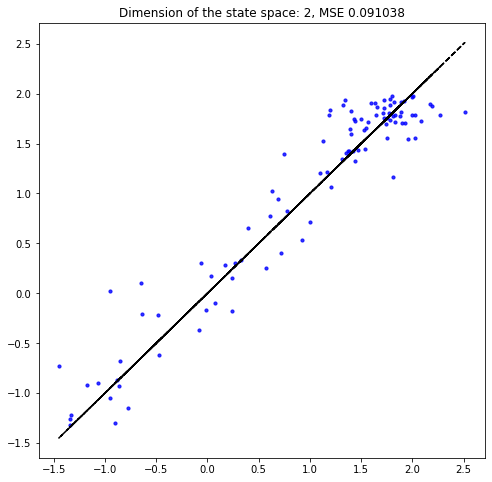

In [62]:
# number of trees in the forest for an elementary random forest estimate
n_trees = 200


rf      =  RandomForestRegressor(n_estimators=n_trees, max_depth = 10, bootstrap=True )
rf.fit(X_train, Y_train)




# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
print('mse is', "%.2e" %mse)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')
send(plt,7)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


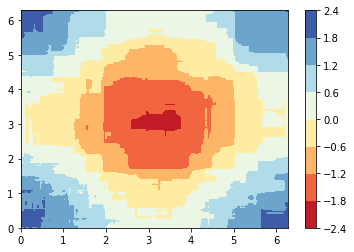

In [63]:
if d==2:
    
    Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    plt.show()

In [64]:
rf.predict(([[1,3]]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([-0.39292298])

<strong><font color=darkorange> Solution 5</font></strong>

mse is 9.31e-02


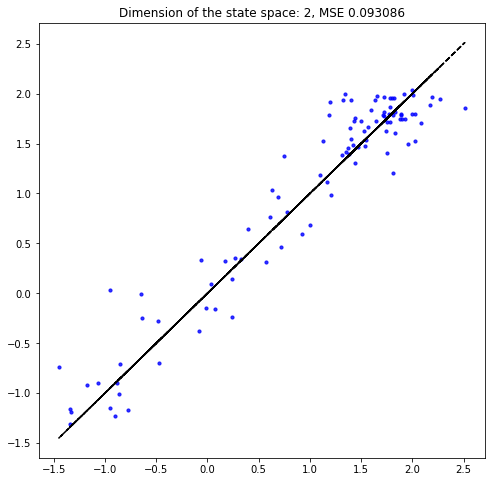

In [65]:
# number of trees in the forest for an elementary random forest estimate
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
print('mse is', "%.2e" %mse)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')
plt.show()

The predictions seem reasonable but it may be that these predictions are very accurate at first and then that the errors accumulate over time.
To test if this is the case, plot the values of $Y$ in the test set (true and predicted) as functions of the time from the last training time.

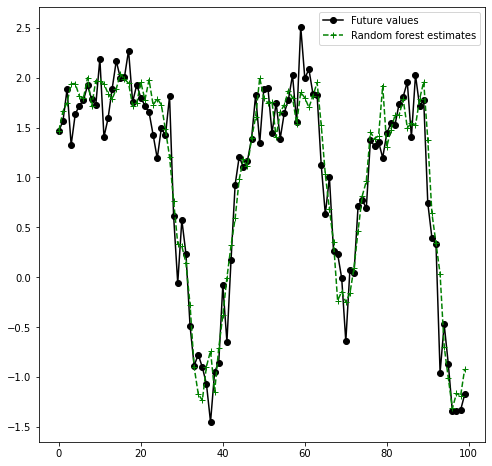

In [66]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))


To improve this first prediction, the different parameters of the random forest algorithm may be tuned. For example, an increase of the number of trees in the forest reduced the variance of the Monte Carlo estimate.

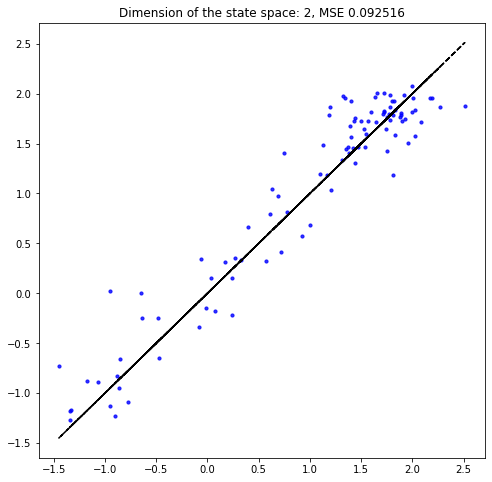

In [67]:
# number of trees in the forest
n_trees = 500
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')

Note that this increases substancially the computational time although predictions seem equally relevant.

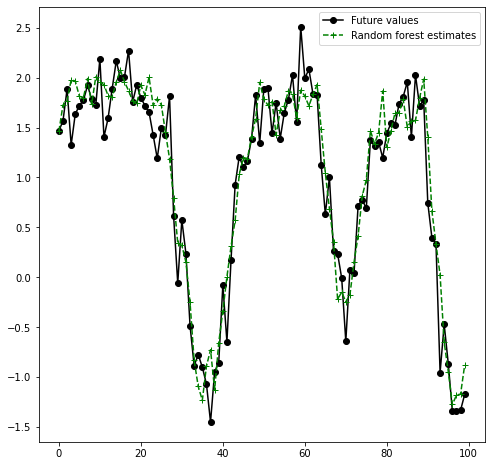

In [68]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

<strong><font color=red> You can skip the next few cells to work directly on the Brazil dataset </font></strong>

The objective is now to improve the algorithm using a cross-validation scheme to estimate the best value of these parameters. It is useful to look at the parameters used by default in the algorithm here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Set a grid of parameters that will be tested by the cross-validation procedure.

In [69]:
# with RandomizedSearchCVCreate, a grid of tuning parameters is built
# then a random search will be performed to test which parameter values yield the best 
# random forest estimate (see below).
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV #check also gridsearchCV
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree. 
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each 
# subcell obtained after the spliting process.
min_samples_leaf = [1, 4, 16, 64]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 4, 16, 64],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Exploring all parameters combinations in this grid would be computationally prohibitive. 
An efficient alternative is to compare parameters chosen at random in the grid.

In [75]:
rf = RandomForestRegressor()
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!).
# search across n_iter = 100 different combinations with a default 3-fold cross validation.
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=20,
                               cv=5,
                               verbose=10,
                               n_jobs=-1)

rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 4, 16, 64],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=10)

In [76]:
# display the best parameters
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 95,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1400}

In [77]:
# build the best explored random forest
best_random = rf_random.best_estimator_

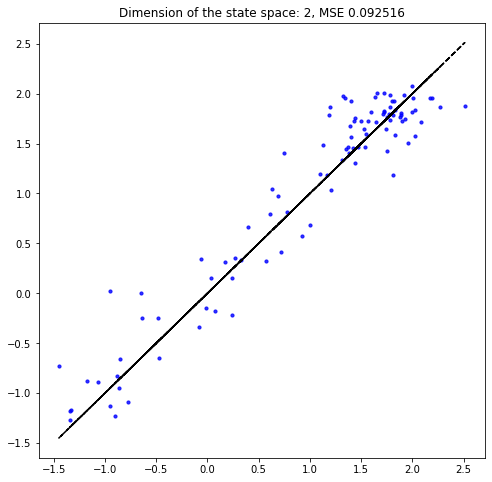

In [78]:
plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


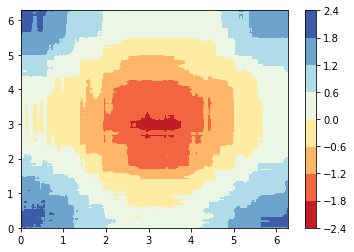

In [79]:
Z = best_random.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
plt.colorbar()
plt.show()

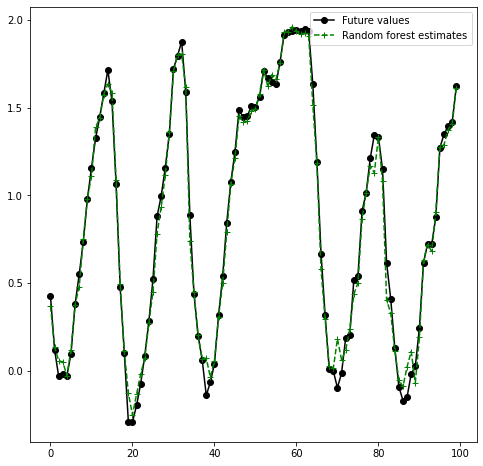

In [67]:
# compute predictions usting test data and associated mean square error
y_pred_rf = rf_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


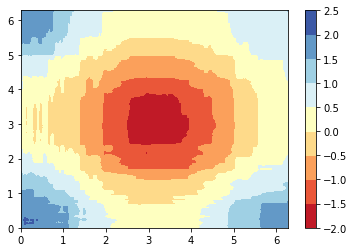

In [89]:
rf_mine = RandomForestRegressor(bootstrap=True,max_depth= 20,max_features= 'log2', min_samples_leaf= 6,
                                min_samples_split=3,n_estimators= 2000)
rf_mine.fit(X_train,Y_train)
Z = rf_mine.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
plt.colorbar()
plt.show()

## <font color=darkred> Random forests for time series prediction - Inflation prediction </font>

In [90]:
! wget -q https://raw.githubusercontent.com/adieulev/Certificate-DS-2021/main/Data/BRinf

<strong><font color=darkorange> Q7</font></strong>:
In the following cell, we import the data on a pandas dataframe. Print the first few lines (use head), the shape of  ```df```.
How many feature are there?

In [ ]:
# In this section, random forests are used to predic the Brazilian inflation based on
# many observed variables, see https://github.com/gabrielrvsc/HDeconometrics/
import pandas as pd
df = pd.read_csv('BRinf')

##### COMPLETE HERE to print first lines
##### COMPLETE HERE TO PRINT SHAPE




In [ ]:
# COMPLETE the ??
send("there are ??? observations and ?? feature", 8)


<strong><font color=darkorange> Solution 7</font></strong>:

In [91]:
# In this section, random forests are used to predic the Brazilian inflation based on
# many observed variables, see https://github.com/gabrielrvsc/HDeconometrics/
import pandas as pd
df = pd.read_csv('BRinf')
df.head()

,Unnamed: 0,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
0,2003-01-31,2.25,2.33,2.17,5.816,2.29,11.56,25422.0,-359,-1.47,...,0.80,0.68,4.0000,1.96,3.8416,0.18,1.3225,1.15,1.3225,0.24
1,2003-02-28,1.57,2.28,1.59,4.351,2.42,10.95,25163.0,-303,-1.21,...,0.68,0.48,2.5600,1.60,2.5600,0.26,0.7569,0.91,0.8281,0.27
2,2003-03-31,1.23,1.53,1.66,4.593,1.58,9.58,24960.0,115,-0.35,...,0.55,0.50,0.8836,0.93,0.8649,0.13,0.4900,0.73,0.5329,0.17
3,2003-04-30,0.97,0.92,0.41,1.173,1.24,8.88,25284.0,93,-0.15,...,0.45,0.78,1.0000,0.97,0.9409,0.14,0.2500,0.52,0.2704,0.18
4,2003-05-31,0.61,-0.26,-0.67,-1.860,0.02,8.22,24785.0,285,-0.47,...,0.60,0.43,0.2500,0.50,0.2500,0.10,0.3025,0.55,0.3025,0.15


In [92]:
# number of observations, number of variables
df.shape

(156, 93)

The function ``pandas.DataFrame.corr`` may be used to compute the pairwise correlations between columns (variables and inflation). These correlations can be displayed using ``sns.heatmap`` to highlight highly correlated variables (and those likely to have an impact on the inflation).

See ``feature_importances_`` below for a first try at (relevant) variable selection.

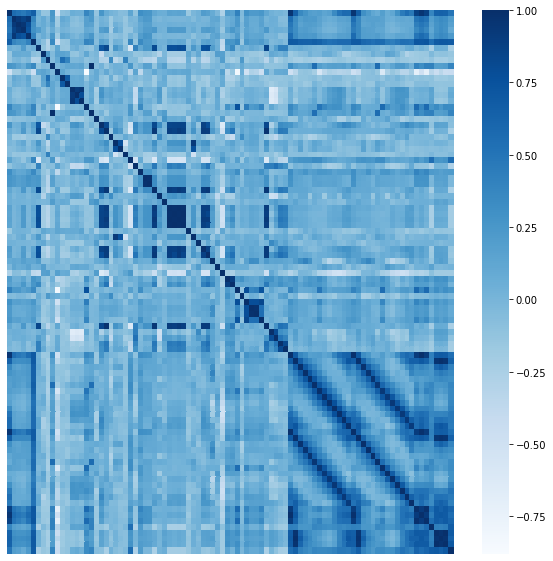

In [93]:
import seaborn as sns
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, xticklabels = False, yticklabels = False, cmap = 'Blues', ax = ax)

<strong><font color=darkorange> Q8</font></strong>: 
- which column are we trying to predict?
- which features have the highest correlation with it?


<strong><font color=darkorange> Solution 8</font></strong>: 
- ```np.argmax(corr.values[0,1:]''' finds the index of the highest correlationon the column 0 (ignoring the first element which has cor 1!)
- we add 2: one for the first element, one for the first empty column

In [94]:
df.columns[np.argmax(corr.values[0,1:])+2]

't.1'

In [95]:
corr.head()

,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
Brazil CPI IPCA MoM,1.000000,0.564057,0.513079,0.472865,0.548028,0.666126,0.051693,-0.138035,-0.128571,0.265466,...,0.548735,0.468353,0.876131,0.960011,0.877122,0.378376,0.632513,0.646564,0.631671,0.500115
FGV Brazil General Prices IGP-,0.564057,1.000000,0.931098,0.875071,0.937050,0.383307,0.015717,0.091837,-0.013777,0.234420,...,0.099243,0.118357,0.496675,0.557056,0.501341,0.198352,0.298803,0.345757,0.311183,0.206675
FGV Brazil General Prices IGP-.1,0.513079,0.931098,1.000000,0.950262,0.792862,0.322426,0.030985,0.083818,0.004757,0.151959,...,0.093295,0.096065,0.428282,0.487584,0.436533,0.161159,0.279579,0.324037,0.288390,0.164378
FGV Brazil General Prices IGP-.2,0.472865,0.875071,0.950262,1.000000,0.735705,0.301127,0.208221,0.073154,-0.067722,0.075466,...,0.088300,0.119306,0.360302,0.451189,0.367995,0.125552,0.276022,0.327440,0.280982,0.096484
FGV Brazil General Prices IGP-.3,0.548028,0.937050,0.792862,0.735705,1.000000,0.411856,-0.002718,0.080790,-0.021884,0.248427,...,0.111940,0.138191,0.499192,0.569468,0.507088,0.183621,0.316816,0.356699,0.330572,0.228943


In [96]:
nb_data_train = 140
nb_diff       = df.shape[0]-nb_data_train
# inflation observations
Y_train = df.iloc[0:nb_data_train,1] 
Y_test  = df.iloc[-nb_diff:,1] 
Y_test.head()

140    0.57
141    0.42
142    0.51
143    0.78
144    1.24
Name: Brazil CPI IPCA MoM, dtype: float64

In [97]:
# other variables
X_train = df.iloc[0:nb_data_train,2:] 
X_test  = df.iloc[-nb_diff:,2:] 
X_test.head()

,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,CNI Brazil Manufacture Industr.1,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
140,0.20,0.02,0.110,0.31,6.34,38551.0,580,-0.22,-0.1,81.8,...,0.35,0.41,0.1849,0.43,0.1849,0.04,0.2500,0.49,0.2401,0.05
141,0.28,0.59,3.158,0.02,6.38,38798.0,-266,-0.63,0.3,82.3,...,0.40,0.53,0.2500,0.50,0.2500,0.04,0.3249,0.58,0.3364,0.05
142,0.98,1.14,6.098,0.82,6.57,40100.0,61,-0.76,-0.6,82.6,...,0.52,0.64,0.3025,0.59,0.3481,0.05,0.5476,0.72,0.5184,0.08
143,0.62,0.38,2.089,0.98,6.67,40950.0,327,-1.48,-0.1,82.0,...,0.64,0.71,0.4900,0.75,0.5625,0.05,0.9409,0.97,0.9409,0.12
144,0.76,0.67,3.672,0.42,7.01,39673.0,-773,-0.82,-0.2,78.6,...,0.72,0.69,1.9600,1.18,1.3924,0.11,1.0201,0.99,0.9801,0.16


<Response [200]>

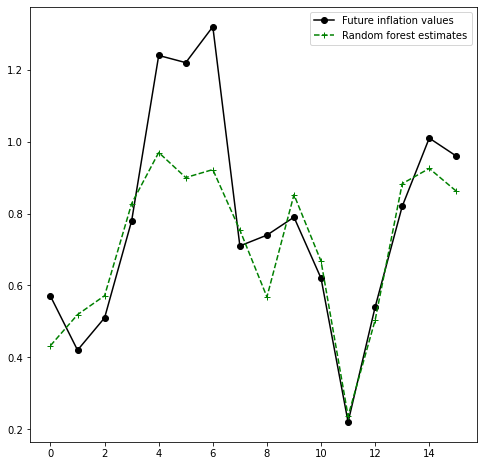

In [98]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)


plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))
send(plt,9)


<strong><font color=darkorange> Q9</font></strong>: 
- What do you think of the quality of the prediction?
- Do you think it is useful to use all explanatory variables?
- Which variables have the most importance? What was the method proposed in the lecture to chose variables?


In [ ]:
### COMPLETE the ??

send("the prediction is ???", 10)
send("we could use ??more/less?? features", 11 ) # chose more or less, guess how many would be useful...
send("we can use the ???? function in sklearn", 12)


<strong><font color=darkorange> Solution 9</font></strong>: 
- Many variables are used for the inflation prediction while very few observations are available.
- Selecting the most valuable variables is an alternativ to learn a simpler models
- This is obtained in Python with rf.feature_importances_

Text(0.5, 1.0, 'Feature importances')

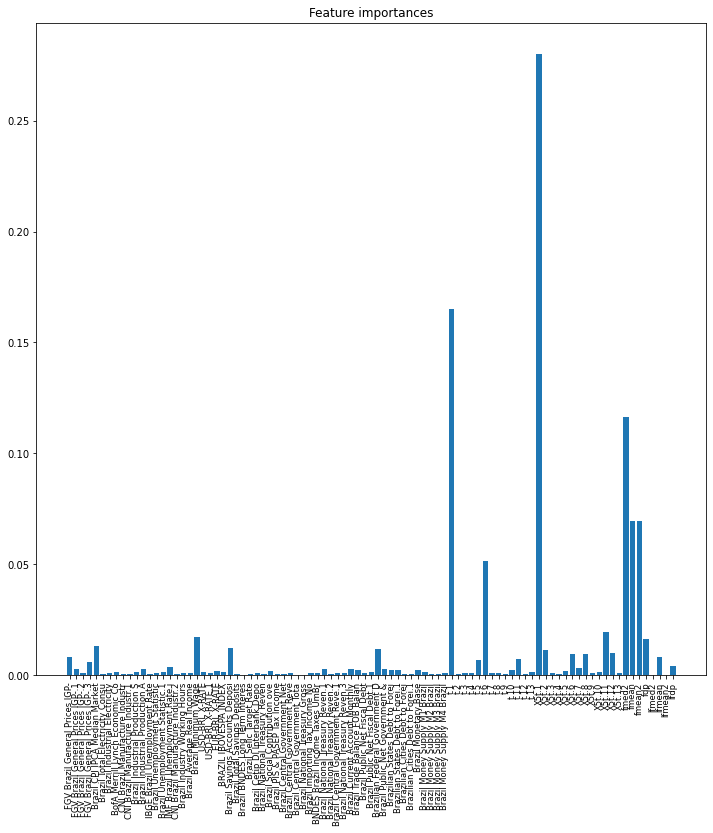

In [99]:
plt.figure(1,figsize=(12,12))
plt.bar(list(df)[2:93],rf.feature_importances_,align='center')
plt.xticks(range(len(list(df)[2:93])),list(df)[2:93],rotation=90,size='small')
plt.title('Feature importances')

RandomForestClassifier and RandomForestRegressor use the gini importance mechanism as a measure of the 
fetaures importance. The mean decrease in impurity importance of a 
feature is computed by measuring the impact of a variable on the variance of the prediction,
see https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf

In [100]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 10
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]

,Brazil CPI IPCA Median Market,fdp,Brazil Minimum Wage,X5t.11,t.6,fmean2,fmean,fmed2,t.1,X5t.1
0,11.56,0.18,200,0.81,0.82,3.8416,1.96,4.0000,2.00,2.10
1,10.95,0.26,200,0.82,1.47,2.5600,1.60,2.5600,1.60,1.65
2,9.58,0.13,200,0.68,0.80,0.8649,0.93,0.8836,0.94,0.95
3,8.88,0.14,200,0.63,0.60,0.9409,0.97,1.0000,1.00,1.10
4,8.22,0.10,240,0.45,0.58,0.2500,0.50,0.2500,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...
135,6.17,0.07,724,0.64,0.39,0.6084,0.78,0.6400,0.80,0.84
136,6.00,0.05,724,0.46,0.50,0.2025,0.45,0.2025,0.45,0.43
137,5.96,0.06,724,0.54,0.57,0.1156,0.34,0.1225,0.35,0.33
138,5.85,0.07,724,0.46,0.64,0.0196,0.14,0.0225,0.15,0.15


<Response [200]>

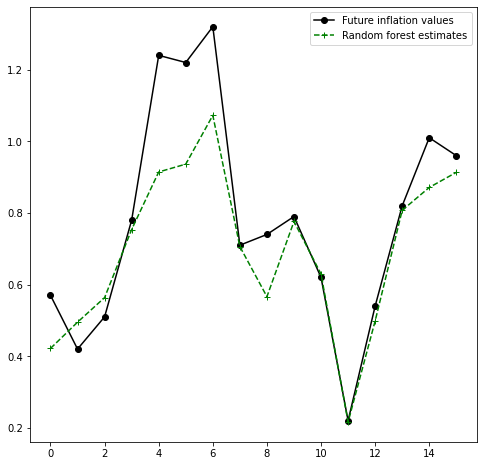

In [101]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))
send(plt,13)

<strong><font color=darkorange> Q10</font></strong>: 
- What do you think of the quality of the prediction?
- How many explanatory variables are we using now?


In [ ]:
# COMPLETE the ??

send("the predictions are ??better/worse??", 14)
send("we are using ?? explanatory variables", 15)

<strong> We now plot the MSE as a function of the numbers of variables used to estimate the function f</strong> 

In [102]:
d_max = 60
MSE   = []
rf    = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)
for d in range(2,d_max): 
    rfd = RandomForestRegressor(n_estimators = n_trees)
    ind = rf.feature_importances_.argsort()[-d:]
    rfd.fit(X_train.iloc[:,ind],Y_train)
    # compute predictions usting test data and associated mean square error
    y_pred_rf = rfd.predict(X_test.iloc[:,ind])
    MSE = np.append(MSE,mean_squared_error(Y_test,y_pred_rf))

<Response [200]>

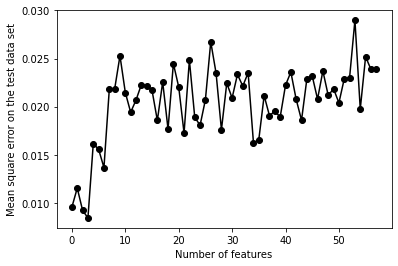

In [103]:
#plt.figure(1,figsize=(8,8))
plt.plot(MSE,marker='o',color='k')
plt.xlabel('Number of features')
plt.ylabel('Mean square error on the test data set')
send(plt,16)

<strong><font color=darkorange> Q11</font></strong>: 
- Which extremely important phenomenon are we observing here? 
- What is the optimal number of explanatory variables?


In [ ]:
# COMPLETE the ??

send("We observe ????", 16)
send("we should use the optimam number of ???? explanatory variables", 17)

<strong><font color=darkorange> Q12</font></strong>: 
- Picking manually the optimal number of features, fit the model and print the predictions !

In [104]:
# collect the indices of the features with highest importance.

nb_features_to_keep = #COMPLETE
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]

n_trees = # COMPLETE

rf      = # COMPLETE
#COMPLETE

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(#COMPLETE)

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
send(plt,18)
plt.legend(labels=('Future inflation values','Random forest estimates'))

SyntaxError: ignored

<strong><font color=darkorange> Solution 11 & 12</font></strong>: 

<Response [200]>

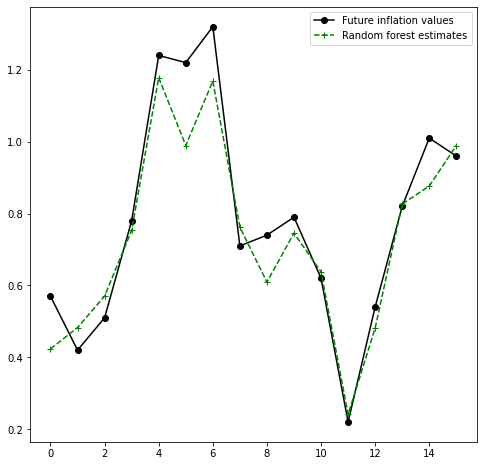

In [105]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 4
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))
send(plt,19)

<strong><font color=darkorange>
- Using too many features results in overfitting: the accuracy on the test set becomes worse
- The optimal predictor uses only the four most important features</font></strong>

In [ ]:
# you may add here a cross validation procedure using RandomizedSearchCV or GridSearchCV
# to select the best parameters (and compare the mean square error with what you obtain above).